# Raman Transition


## Atomic Circuit


In [1]:
import numpy as np
from oqd_core.interface.atomic import (  # noqa: F401
    AtomicCircuit,
    Beam,
    ParallelProtocol,
    Phonon,
    Pulse,
    System,
    Yb171IIBuilder,
)

Yb171 = Yb171IIBuilder().build(["q0", "q1", "e1m"])
COM_x = Phonon(energy=2 * np.pi * 1e6, eigenvector=[1, 0, 0])
system = System(ions=[Yb171], modes=[COM_x])


beam = Beam(
    transition="q0->e1m",
    rabi=2 * np.pi * 1e10,
    detuning=2 * np.pi * 33.195e12,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)
beam2 = Beam(
    transition="q1->e1m",
    rabi=2 * np.pi * 1e10,
    detuning=2 * np.pi * 33.195e12,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)


protocol = ParallelProtocol(
    sequence=[
        Pulse(beam=beam, duration=1e-6),
        Pulse(beam=beam2, duration=1e-6),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [2]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("1_raman.json", "w") as f:
    f.write(circuit_json)

In [3]:
with open("1_raman.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


### Compile


In [4]:
from oqd_compiler_infrastructure import Chain, Post, Pre

from oqd_trical.backend import DynamiqsBackend, QutipBackend  # noqa: F401
from oqd_trical.light_matter.compiler.approximate import (
    AdiabaticElimination,
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    "E0": [
        Yb171.levels[0].energy,
        Yb171.levels[1].energy,
        2 * np.pi * 33.195e12 + Yb171.levels[2].energy,
    ],
    "P0": 2 * np.pi * 1e6,
}

eliminated_specs = (2, "E0")

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 1e9)),
    canonicalize_emulator_circuit_factory(),
    Pre(AdiabaticElimination(eliminated_specs=eliminated_specs)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 3
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

D:\work\Projects\TrICal\src\oqd_trical\light_matter\compiler\approximate.py:424: UserWarning: Caution required when using adiabatic elimination, system needs to be put in the appropriate rotating reference frame.
  warnings.warn(


In [5]:
from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(hilbert_space), "=" * 80, printer(backend.intermediate), sep="\n")

HilbertSpace
  - hilbert_space: dict
    - E0: set({0, 1})
    - P0: set({0, 1, 2})
AtomicEmulatorCircuit
  - frame: Operator(79437055201.61006 * |1><1|_E0 @ I_P0 + 6283185.307179586 * I_E0 @ C_P0 * A_P0)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(2366013.4459932228 * |0><0|_E0 @ D(0.09623866507311524 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 2366013.445993222 * |1><0|_E0 @ D(0.09623866507311524 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 2366013.4459932228 * |0><0|_E0 @ D(0.09623866507311524 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)))_P0 + 2366013.445993222 * |0><1|_E0 @ D(0.09623866507311524 * exp(1j * (6283185.307179586 * t + -1.5707963267948966)))_P0 + 2366013.4459932223 * |0><1|_E0 @ D(0.09623722430581576 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 2366013.4459932214 * |1><1|_E0 @ D(0.09623722430581576 * exp(1j * (6283185.307179586 * t + 1.5707963267948966)))_P0 + 2366013.44

### Run


In [6]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-9,
)

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.12s. Est. time left: 00:00:00:00
40.0%. Run time:   0.13s. Est. time left: 00:00:00:00
50.0%. Run time:   0.15s. Est. time left: 00:00:00:00
60.0%. Run time:   0.17s. Est. time left: 00:00:00:00
70.0%. Run time:   0.18s. Est. time left: 00:00:00:00
80.0%. Run time:   0.20s. Est. time left: 00:00:00:00
90.0%. Run time:   0.21s. Est. time left: 00:00:00:00
100.0%. Run time:   0.23s. Est. time left: 00:00:00:00
Total run time:   0.23s


#### Results


In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

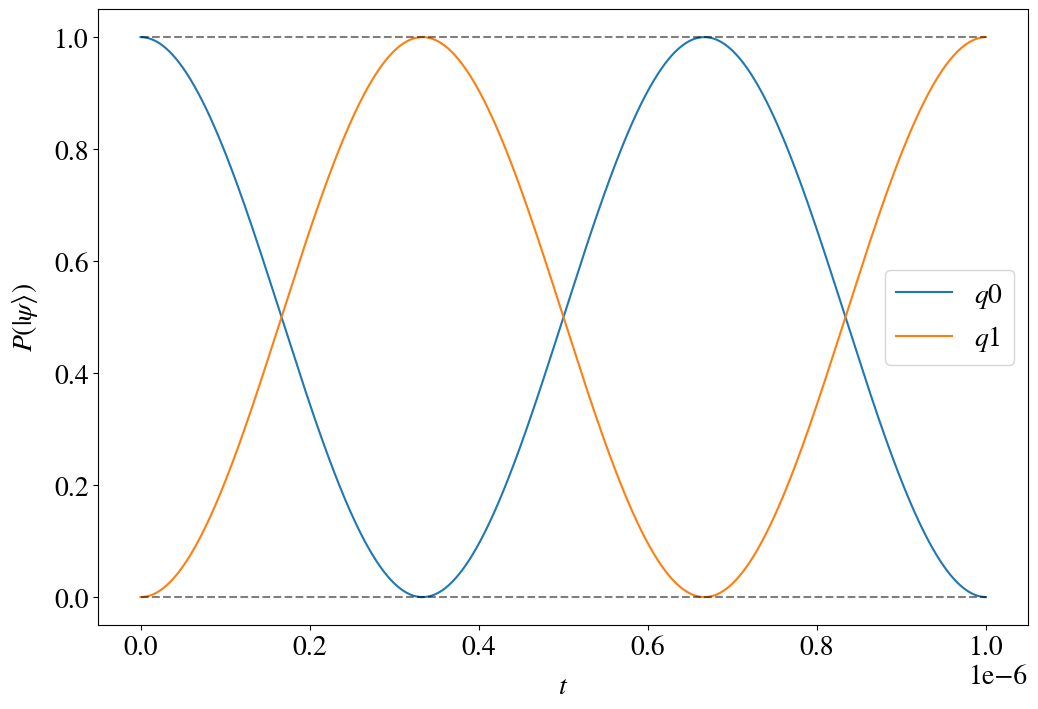

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:] for s in result["states"][k]],
    label=[rf"${level.label}$" for level in Yb171.levels[:2]],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

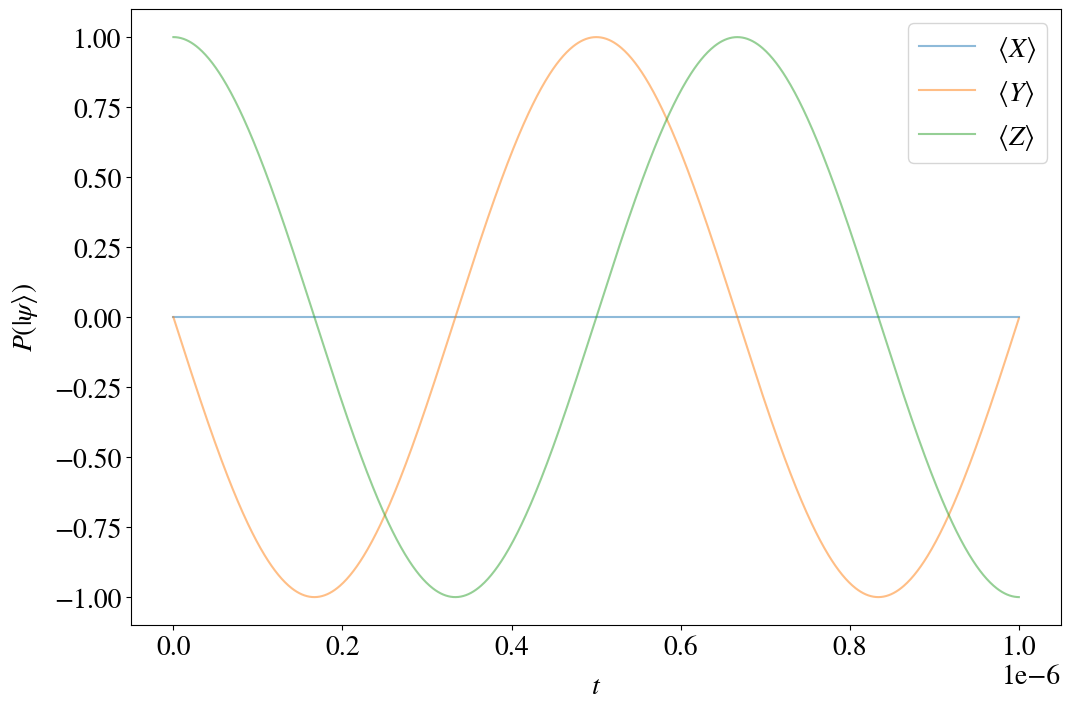

In [9]:
import qutip as qt

k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

X, Y, Z, I = qt.sigmax(), qt.sigmay(), qt.sigmaz(), qt.identity(2)  # noqa: E741


paulis = {
    "X": X,
    "Y": Y,
    "Z": Z,
}

expections = ["X", "Y", "Z"]

plot_states = [
    [qt.expect(paulis[o], s.ptrace([0])) for o in expections]
    for s in result["states"][k]
]

ax.plot(
    result["tspan"][k],
    plot_states,
    label=[rf"$\langle {o}\rangle$" for o in expections],
    alpha=0.5,
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

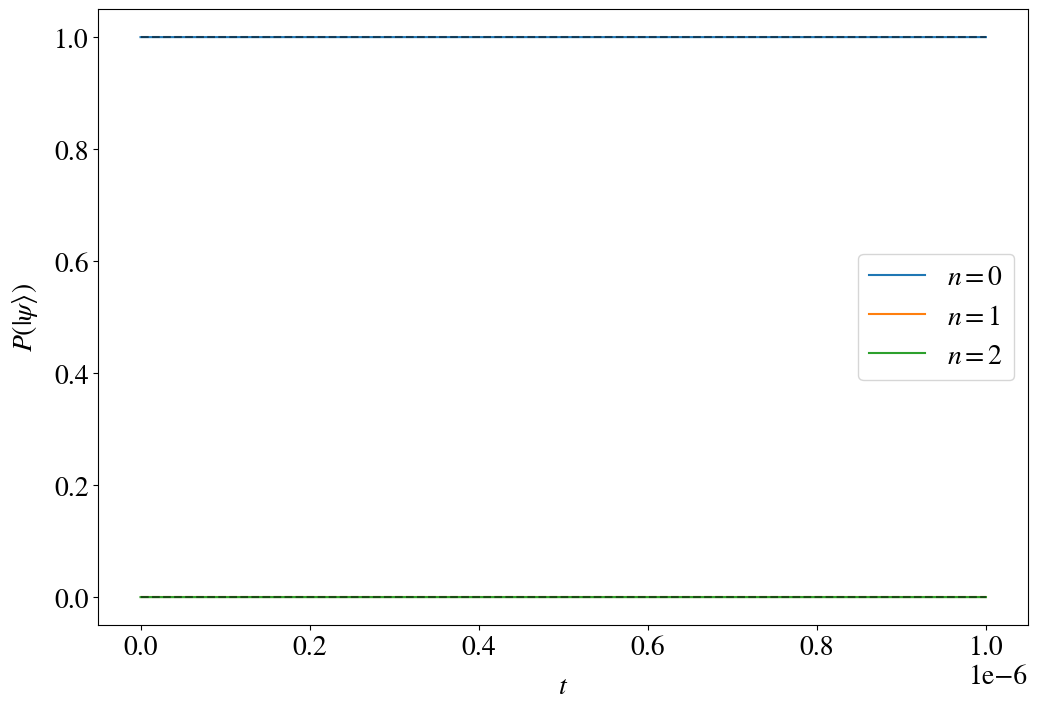

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:] for s in result["states"][k]],
    label=[rf"$n={n}$" for n in range(fock_cutoff)],
)
ax.plot(
    result["tspan"][k], np.zeros_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)
ax.plot(
    result["tspan"][k], np.ones_like(result["tspan"][k]), ls="--", color="k", alpha=0.5
)


ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()